# Deep Learning course - LAB 7

## ConvNets 101

### Recap from previous Lab

* we introduced some basic image processing functionalities with OpenCV
* we saw how to import a custom dataset in PyTorch, how to operate data augmentation, and how to create a DataLoader out of it

### Agenda for today

* we will construct our first Convolutional Neural Network (CNN)
* we will show how to do transfer learning on CNNs
* we will show how to introduce Deconvolution/Inverse Convolution inside CNNs
* we will construct our own implementation of the ResNet
* we will learn about the U-Net, a CNN for image segmentation

## Our first CNN

Building CNNs is actually not hard once you know all the pieces to construct a MultiLayer Perceptron.

We can distinguish between two macro-categories of CNNs, at least for the part concerning image classification. We might call them "historical" and "modern", although characteristics of both can sometimes get pretty much mixed-up.

* "Classical" ("Historical") CNNs are a stack composed of two parts:
  * a **convolutional** part, where have a cascade of convolutional layers intertwined with pooling layers for dimensionality and complexity reduction
    * usually the filters in each convolutional layer are more numerous as the image size shrinks (i.e., as we get further from the input)
  * a **fully-connected** part, where we have a sequence of few fully-connected layer, ending up in the output layer, where, as usual, we have as many neurons as there are categories
  
 the epitome of the historical CNN (which is still used in research today nonetheless) is VGGNet (or simply VGG) [5](https://arxiv.org/abs/1409.1556v6). Its *core* is a **convolutional block** composed of two or three convolutional layers each with the same number of filters, which is double the number of filters of the previous layer, up to 512 filters per layer. At the end of each block, there's a Max Pooling layer which halves the spatial dimension of the image.

 In the picture below, you can see a modern implementation of VGG with only one fully-connected layer.
  ![](img/vgg.png)
  


* "Modern" CNNs, instead, get rid of the fully-connected part, as usually
    1. it introduces a considerable amount of parameters in the network (note that the convolutional layers, due to their local connectivity and shared weights, have a much lower number of parameters w.r.t. fully connected layers)
    2. it keeps the 2D spatial structure of the image intact up to the last hidden layer, allowing for more interpretal parameters/neurons (*insert Olah citation here*)
    3. it represents a "rigid" portion of the network in the sense that it constrains they size of the image to be fixed. We will see later how this can pose a problem.

 Sometimes, even the pooling layers may get replaced by convolutional layers with large kernel size, as its effect is to reduce dimensionality (i.e., height and width) of the corresponding image.
 
 Recently, the **residual block** has become one of the paramount structures in modern CNNs.

 "Classical" CNNs stack a large number of convolutional layers on top of each other. This though can lead to problems such as the **vanishing gradient**. In a periodic fashion, resnets introduce **skip connections**:
    * given the layer of index $k$, we call $a_k$ its output/activation
    * $a_k$ gets pushed towards the next layer $k+1$, but we also "propagate" it *after* the layer $k+m$ (usually $m$ is 1 or 2) and we sum $a_k$ to $a_{k+m}$.
    
 More on that later.

 ![](img/resnet.png)

 In the diagram above there're two residual blocks. The skip connections are indicated with the protruding connector.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torchvision.models import vgg11_bn
from torchsummary import summary
from scripts import mnistm
from scripts import mnist
from scripts import train
from matplotlib import pyplot as plt

In [60]:
class CNN(nn.Module):
    def _build_vgg_block(self, num_conv_layers, in_channels, out_channels, kernel_size=3, batchnorm=True, activation=nn.ReLU, maxpool=True):
        layers = []
        for i in range(num_conv_layers):
            if i == 0:
                num_channels_in = in_channels
            else:
                num_channels_in = out_channels
            
            layers.append(nn.Conv2d(in_channels=num_channels_in, out_channels=out_channels, kernel_size=kernel_size))
            if batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation())
        
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers)

    def __init__(self, num_classes=10, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            self._build_vgg_block(2, in_channels, 16, activation=nn.SiLU),
            self._build_vgg_block(2, 16, 32, activation=nn.SiLU)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, X):
        return self.classifier(self.avgpool(self.features(X)))

In [62]:
net = CNN(in_channels=3)
_ = summary(net)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  448
|    |    └─BatchNorm2d: 3-2             32
|    |    └─SiLU: 3-3                    --
|    |    └─Conv2d: 3-4                  2,320
|    |    └─BatchNorm2d: 3-5             32
|    |    └─SiLU: 3-6                    --
|    |    └─MaxPool2d: 3-7               --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-8                  4,640
|    |    └─BatchNorm2d: 3-9             64
|    |    └─SiLU: 3-10                   --
|    |    └─Conv2d: 3-11                 9,248
|    |    └─BatchNorm2d: 3-12            64
|    |    └─SiLU: 3-13                   --
|    |    └─MaxPool2d: 3-14              --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Flatten: 2-3                      --
|    └─Linear: 2-4                       330
Total params: 17

Test if the net works on random data

In [4]:
X = torch.rand((100,3,28,28))
y = net(X)
y.shape

torch.Size([100, 10])

Let's go more in detail in the computation

In [5]:
z = X
print("in", z.shape)
for i, mod in enumerate(net.features):
    z = mod(z)
    print(i, z.shape)

z = net.avgpool(z)
print("avgpool", z.shape)

z = net.classifier(z)
print("out", z.shape)

in torch.Size([100, 3, 28, 28])
0 torch.Size([100, 16, 12, 12])
1 torch.Size([100, 32, 4, 4])
avgpool torch.Size([100, 32, 1, 1])
out torch.Size([100, 10])


In [6]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4639, 0.4676, 0.4199], [0.2534, 0.2380, 0.2618]), # I pre-computed these data
])

mnistm_train = mnistm.MNISTM(root="datasets/MNISTM", download=True, transform=transforms)
mnistm_test = mnistm.MNISTM(root="datasets/MNISTM", train=False, download=True, transform=transforms)

Processing...
C:\Users\mzullich\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\mzullich\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
Done!


Ground truth: 5


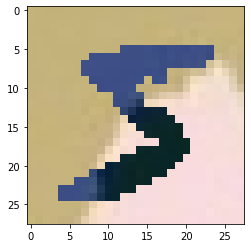

In [7]:
img = (mnistm_train.train_data[0].numpy() * 255).astype("uint8")
plt.imshow(img)
print("Ground truth:", mnistm_train.train_labels[0].item())

In [8]:
mnistm_test.test_data.shape, mnistm_test.test_labels.shape

(torch.Size([10000, 28, 28, 3]), torch.Size([10000]))

In [10]:
batch_train = 128
batch_test = 512
mnistm_trainloader = DataLoader(mnistm_train, batch_train, shuffle=True, num_workers=8)
mnistm_testloader = DataLoader(mnistm_test, batch_test, shuffle=False, num_workers=8)

In [11]:
optim = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=5e-4, momentum=.9)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=12)

In [12]:
train.train_model(net, mnistm_trainloader, loss_fn=nn.CrossEntropyLoss(), optimizer=optim, num_epochs=50, lr_scheduler=scheduler)

Epoch 1 --- learning rate 0.10000


KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), "models_push/cnn_mnistm/model.pt")

In [63]:
net.load_state_dict(torch.load("models_push/cnn_mnistm/model.pt")) #-> Now model is on CPU!!

<All keys matched successfully>

In [64]:
train.test_model(net, mnistm_testloader)

TESTING - loss -- - performance 0.9790


(None, 0.979)

### Transfer Learning

Transfer Learning is the utilization of a model, built for a given task (**upstream task**) on one or more different tasks (**downstream task**).

Usually, in Deep Learning we operate a **model finetuning**, i.e., we use a model fully-trained on the upstream task and we adapt it someway on the downstream task.

Fine-tuning comes in different flavors:

1. we might just re-use the model for the upstream task without re-training

2. we might want to re-train the model on the downstream task leaving fixed the parameters of the majority of the layers, while re-training only the remaining parameters.
 Usually, we train only the weights in the final fully-connected layer. This method is called **feature extraction**.

3. we might want to fully re-train the model, using the `state_dict` from the upstream task as an **initialization** for the training on the downstream task. This is the proper **fine-tuning**.

NB: if the ground truth for the downstream task and the upstream task have different domain (e.g. different number of categories), I'll need to modify the architecture of my CNN by **changing the number of output features** of the last layer. This, of course, will mean that the weights in this layer need to be re-initialized, hence, we'll for sure need to resort to strategies 2 or 3.

NB2: a common techinque which is operated for **small downstream tasks datasets** is to obtain the features before classification (or, in principle, before any one of the layers of my CNN) and to operate feature extraction by fitting a **linear SVM** on top of these features (similar, in principle, to re-training on the last layer only, but with different loss). This approach has been shown to be much more robust to small dataset size.

#### Re-use the same model on MNIST

Basically, we wish to do this:

![](img/tl1.jpg)

We just need to import MNIST.

In [15]:
_, _, mnist_train, mnist_test = mnist.get_data()
mnist_train.data.shape

torch.Size([60000, 28, 28])

Have a look at the shape.

**Q**: What do we need to do?


In [16]:
class MNIST_3(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset, transform=None):
        n, h, w = mnist_dataset.data.shape
        self.data = mnist_dataset.data.clone().unsqueeze(1).expand(n, 3, h, w)
        self.targets = mnist_dataset.targets.clone()
        if transform is None:
            self.transform = lambda x: x
        else:
            self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.transform(self.data[index]), self.targets[index]

In [17]:
transforms_mnist = T.Compose([
    lambda x: x/255,
    T.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
])
mnist3_train = MNIST_3(mnist_train, transforms_mnist)
mnist3_test = MNIST_3(mnist_test, transforms_mnist)

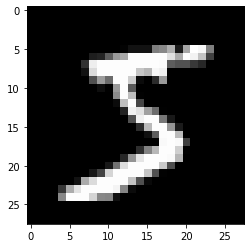

In [18]:
plt.imshow(mnist3_train.data[0].permute(1,2,0))

In [66]:
mnist_trainloader = DataLoader(mnist3_train, 512, shuffle=False, num_workers=0)
mnist_testloader = DataLoader(mnist3_test, 512, shuffle=False, num_workers=0)

In [67]:
train.test_model(net, mnist_trainloader)
train.test_model(net, mnist_testloader)

TESTING - loss -- - performance 0.8296
TESTING - loss -- - performance 0.8285


(None, 0.8285)

We see that the performance is *kinda good*, but we'd expect more out of a model on MNIST.

#### Feature extraction

Basically we do this:

![](img/tl2.jpg)

What we need to do:

1. Freeze the training in the layers from the first to the second-to-last by *inhibiting* the `grad` in these layers
2. Create the optimizer passing only the parameters of the last layer

Notice that, if we consider the `named_parameters` of our net, the weight and bias of the last layer share the name `classifier.1`. Knowing that, we can inhibit the gradient by setting `param.requires_grad` to `False`.

In [ ]:
for name, pars in net.named_parameters():
    if "classifier.1" not in name:
        pars.requires_grad = False

Mirroring the strategy above, we can *filter* the parameters being trained by the optimizer with a list comprehension:

In [ ]:
optim_finetune = torch.optim.SGD([pars for name, pars in net.named_parameters() if "classifier.1" in name], lr=.1, momentum=.9, weight_decay=5e-4)
train.train_model(net, mnist_trainloader, nn.CrossEntropyLoss(), optim_finetune, 5)

### Proper finetuning (ILSVRC2012 → CIFAR10)

`torchvision` enables us to directly download pre-trained models from the web. Normally, we can access the weights of a large array of CNNs pretrained on the large-scale image classification dataset `ILSVRC2012`, also known as ImageNet, although the proper ImageNet dataset is a larger version of `ILSVRC2012`.

These CNNs have the last layer whose output size is 1000 (the number of classes in `ILSVRC2012`).

We wish to fine-tune a pre-trained `vgg11` model on the CIFAR10 dataset.

This dataset is comparable in size to MNIST, with 10 categories:

![](https://user-images.githubusercontent.com/16641054/46775076-8b17e480-cd40-11e8-9501-89c6fbca36bd.jpg)

The images are slightly larger ($32 \times 32$ instead of $28 \times 28$) and are encoded as RGB (→ 3 channels).

Let's import the dataset and create the DataLoaders

In [ ]:
transform_cifar = T.Compose([T.ToTensor(), T.Normalize([0.4913997551666284, 0.48215855929893703, 0.4465309133731618], [0.24703225141799082, 0.24348516474564, 0.26158783926049628])])

cifar_train = CIFAR10("datasets/CIFAR", train=True, transform=transform_cifar, download=True)
cifar_test = CIFAR10("datasets/CIFAR", train=False, transform=transform_cifar, download=True)

In [ ]:
cifar_trainloader = DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_testloader = DataLoader(cifar_test, batch_size=512, shuffle=True)

In [ ]:
print("Shape of trainset", cifar_train.data.shape)
print("Num classes", max(cifar_test.targets) + 1)

#### VGG11 

VGG11 is a network similar to the CNN we created before:

![](https://www.researchgate.net/publication/336550999/figure/fig1/AS:814110748987402@1571110536721/Figure-S1-Block-diagram-of-the-VGG11-architecture-Adapted-from-https-bitly-2ksX5Eq.png)

In addition to the picture above, we also use batchnorm (at the time of the invention of VGG, batchnorm wasn't known).

In [ ]:
vgg = vgg11_bn(pretrained=True)
vgg.classifier[-1].out_features = 10 # update the num_classes to reflect the new dataset

Let's see how the network performs without fine-tuning:

In [ ]:
train.test_model(vgg, cifar_testloader)

In the next cells, you'll find how to fine-tune the CNN. It takes around 10 mins on single GPU, so I leave the commands and output as markdown notes.

*You can find the weights under the `models_push/vgg11_cifar` folder.* Note: since the state_dicts are very heavy, I transfered them on Teams (folder `Additional Material for Labs`).

Then, I'll also show how to train the `VGG11_bn` from scratch and leave the output of the training. You can clearly notice how the performance of the fine-tuned model is much better after 20 epochs (actually, this is not shown in the output, but the performance at epoch 1 is much higher in the pre-trained model).

With proper data augmentation and lr scheduling (and maybe a deeper CNN), we can actually reach a test-set accuracy of 94% or higher.

```
optimizer = torch.optim.Adam(vgg.parameters())
train.train_model(vgg, cifar_trainloader, nn.CrossEntropyLoss(), optimizer, 20)
```

```
Epoch 10 completed. Loss - total: 5852.242087006569 - average: 0.11704484174013138; Performance: 0.96644

Epoch 11 completed. Loss - total: 5551.681170940399 - average: 0.11103362341880799; Performance: 0.9682

Epoch 12 completed. Loss - total: 5018.1823744773865 - average: 0.10036364748954774; Performance: 0.9718

Epoch 13 completed. Loss - total: 17709.622314095497 - average: 0.35419244628190993; Performance: 0.92888

Epoch 14 completed. Loss - total: 17280.205318450928 - average: 0.34560410636901856; Performance: 0.89974

Epoch 15 completed. Loss - total: 3871.2677970528603 - average: 0.0774253559410572; Performance: 0.97692

Epoch 16 completed. Loss - total: 2241.83546949178 - average: 0.0448367093898356; Performance: 0.9872

Epoch 17 completed. Loss - total: 2088.5263759568334 - average: 0.041770527519136666; Performance: 0.9882

Epoch 18 completed. Loss - total: 2305.237785771489 - average: 0.04610475571542978; Performance: 0.98758

Epoch 19 completed. Loss - total: 2979.0519604235888 - average: 0.05958103920847178; Performance: 0.98364

Epoch 20 completed. Loss - total: 3053.6747498363256 - average: 0.06107349499672651; Performance: 0.98368
```

```
train.test_model(vgg, cifar_testloader)
```

```
TESTING - loss -- - performance 0.8552
```

```
torch.save(vgg.state_dict, "models/vgg11_cifar/vgg11_tl.pt")
```

Let's compare it with a VGG11_bn trained from scratch

```
vgg2 = vgg11_bn(pretrained=False, num_classes=10)
optimizer = torch.optim.Adam(vgg2.parameters())
train.train_model(vgg2, cifar_trainloader, nn.CrossEntropyLoss(), optimizer, 20)
```

```
Epoch 10 completed. Loss - total: 48581.04235076904 - average: 0.9716208470153809; Performance: 0.66648

Epoch 11 completed. Loss - total: 39186.03456878662 - average: 0.7837206913757324; Performance: 0.72996

Epoch 12 completed. Loss - total: 35287.52504825592 - average: 0.7057505009651184; Performance: 0.76124

Epoch 13 completed. Loss - total: 38614.65808200836 - average: 0.7722931616401673; Performance: 0.7412

Epoch 14 completed. Loss - total: 30812.80309009552 - average: 0.6162560618019104; Performance: 0.79158

Epoch 15 completed. Loss - total: 30947.483282089233 - average: 0.6189496656417847; Performance: 0.79536

Epoch 16 completed. Loss - total: 30550.97905731201 - average: 0.6110195811462402; Performance: 0.80206

Epoch 17 completed. Loss - total: 23598.16388607025 - average: 0.471963277721405; Performance: 0.85028

Epoch 18 completed. Loss - total: 32089.43673324585 - average: 0.641788734664917; Performance: 0.80358

Epoch 19 completed. Loss - total: 37266.2276263237 - average: 0.745324552526474; Performance: 0.78556

Epoch 20 completed. Loss - total: 23250.735929965973 - average: 0.4650147185993195; Performance: 0.84466
```

```
train.test_model(vgg2, cifar_testloader)
```

```
TESTING - loss -- - performance 0.7927
```

```
torch.save(vgg.state_dict(), "models/vgg11_cifar/vgg11_scratch.pt")
```

### ResNets [3](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)

As told before, the building block of resnets is the **residual block**, which enables the network to train faster and avoid the vanishing gradient problem:

![](https://www.aiuai.cn/uploads/sina/5ce8dfe46e373.jpg)

From the image above, we see two popular implementations of the residual block.

* the first implementation is the simplest one. We have two $3\times 3$, 1-padding, convolutions and the same number of filters as the incoming data.

 We can obtain the spatial dimension of the output (i.e., height and width) with this formula (found in [1](https://arxiv.org/abs/1603.07285)): $\text{output_size} = \text{in_size} + 2\cdot \text{pad} - \text{ker_size} + 1$. Since $p=1,~\text{pad}=2,~\text{ker_size}=3$, then $\text{output_size} = \text{in_size}$. Since we do not vary the number of channels in the data, we can safely sum the incoming data to the output of the second convolutional layer.
    * In some layers (architecture-dependent) a *subsampling* may be required (i.e., we need to decrease the spatial dimensions of the data). This is solved by applying a convolution with stride of 2 (the moving window *shifts* by 2 pixels instead of 1).
     
     In this case, **we need to downsample the data in the skip connections** as well. This is done via **$1\times 1$ convolutions with stride of 2**.

 Let's implement this:

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, n_channels, activ=nn.ReLU, bias=False, batchnorm=True, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=bias, stride=(2 if downsample else 1))
        self.bnorm1 = nn.BatchNorm2d(n_channels)
        self.activ1 = activ()

        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=bias)
        self.bnorm2 = nn.BatchNorm2d(n_channels)
        self.activ2 = activ()

        if downsample:
            # correction!! Padding is 0 otherwise dimensions don't match!!
            self.conv_down = nn.Conv2d(in_channels=in_channels, out_channels=n_channels, kernel_size=1, stride=2, padding=0, bias=bias)
            self.bnorm_down = nn.BatchNorm2d(n_channels) # note that this is necessary in order to put data in the skip connection and data in the regular stream on the same domain!
        
        self.downsample = downsample
            
    def forward(self, X):
        out = self.activ1(self.bnorm1(self.conv1(X)))
        out = self.bnorm2(self.conv2(out))

        #### SKIP CONNECTION
        skip = X
        if self.downsample:
            skip = self.bnorm_down(self.conv_down(X))  
        out = self.activ2(out + skip)
        return out

* the second implementation is also called a **bottleneck layer** and operates an expansion of the number of channels (in a fashion similar to VGG). Differently from the residual block:
    * the bottleneck has 3 instead of 2 convolutional layers
        * the 1st and 3rd layer operate a $1\times 1$ correlation with no padding (thus, leaving the image untouched in size)
        * the 2nd is a regular $3\times 3$ correlation which we saw before (padding of 1); however this can be a "**dilated convolution**":
         ![](https://www.researchgate.net/publication/320195101/figure/fig2/AS:669211164692494@1536563783748/Dilated-convolution-On-the-left-we-have-the-dilated-convolution-with-dilation-rate-r.png)
    * the width of the convolutional layers is controlled by a parameter (it should be $\geq$ than the width of the incoming data -- canonical values are 64, 128...)
    * the output of the block has a number of channels which is usually $\times 4$ the width of the block.
    * if a **downsampling** is required, it's operated by setting the stride to 2 for the second convolutional layer only.
     
     As in the basic Residual Block, the input is downsampled via a $1\times 1$ convolution with stride 2.

In [53]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, n_channels, activ=nn.ReLU, bias=False, batchnorm=True, dilation_rate=1, expansion_factor=4, downsample=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=n_channels, kernel_size=1, padding=0, bias=bias)
        self.bnorm1 = nn.BatchNorm2d(n_channels)
        self.activ1 = activ()

        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=bias, dilation=dilation_rate,  stride=(2 if downsample else 1))
        self.bnorm2 = nn.BatchNorm2d(n_channels)
        self.activ2 = activ()

        out_channels = n_channels * expansion_factor
        self.conv3 = nn.Conv2d(in_channels=n_channels, out_channels=out_channels, kernel_size=1, padding=0, bias=bias)
        self.bnorm3 = nn.BatchNorm2d(out_channels)
        self.activ3 = activ()

        if downsample:
            self.down_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, padding=0, stride=2)
            self.down_bn = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, X):
        # prints for clarity on data dimensionality
        out = self.activ1(self.bnorm1(self.conv1(X)))
        print(out.shape)
        out = self.activ2(self.bnorm2(self.conv2(out)))
        print(out.shape)
        out = self.bnorm3(self.conv3(out))
        print(out.shape)
        
        #### SKIP CONNECTION
        skip = X
        if self.downsample:
            skip = self.down_bn(self.down_conv(X))
        print(skip.shape)
        out += skip
        out = self.activ3(out)
        print("---")
        return out

In [54]:
net = nn.Sequential(
    BottleneckBlock(256, 64), # dimension will be 256→64→64→256
    BottleneckBlock(256, 64),
    BottleneckBlock(256, 128, downsample=True) # dimension will be 256→128→128→512 with downsampling of spatial dims
)
X = torch.rand((24, 256, 100, 100))
_ = net(X)

torch.Size([24, 64, 100, 100])
torch.Size([24, 64, 100, 100])
torch.Size([24, 256, 100, 100])
torch.Size([24, 256, 100, 100])
---
torch.Size([24, 64, 100, 100])
torch.Size([24, 64, 100, 100])
torch.Size([24, 256, 100, 100])
torch.Size([24, 256, 100, 100])
---
torch.Size([24, 128, 100, 100])
torch.Size([24, 128, 50, 50])
torch.Size([24, 512, 50, 50])
torch.Size([24, 512, 50, 50])
---


#### Resnet18

Resnet18 is the simplest resnet architecture (18 total layers) presented in [2]. Let's see how we can implement it:

![](https://pytorch.org/assets/images/resnet.png)

From the image above, we can see that the Resnet18 is composed of one initial convolution (preparatory layer), four residual blocks, and one flattening/classification block.

##### Preparatory layer

Is a $7\times 7$ convolution with stride 2 and 64 output channels, followed by batchnorm, relu, and maxpooling with a $3\times 3$ kernel (!) and stride 2.

Its function is mainly to reduce the image in size while extracting a large array of low-level features.


In [21]:
class ResNetPrep(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, activ=nn.ReLU, bias=False):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            activ(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
    def forward(self, X):
        return self.layers(X)

##### Residual blocks

We have eight residual blocks with increasing number of channels, VGG-style (64,64→128,128→256,256→512,512).

Whenever the number of channels is increased, we have also a subsampling.

##### Average pooling and classification

We flatten the array with "adaptive average pooling", which is a nice way to say that we're averaging across width.

Now, we can start preparing our Resnet18 class.

In [68]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10, in_channels=3, base_width=64, activ=nn.ReLU):
        super().__init__()
        self.prep = ResNetPrep(in_channels=in_channels, out_channels=base_width, activ=activ)
        self.res_blocks = nn.Sequential(
            ResidualBlock(in_channels=base_width, n_channels=base_width, activ=activ),
            ResidualBlock(in_channels=base_width, n_channels=base_width, activ=activ),

            ResidualBlock(in_channels=base_width, n_channels=base_width * 2, activ=activ, downsample=True),
            ResidualBlock(in_channels=base_width * 2, n_channels=base_width * 2, activ=activ),

            ResidualBlock(in_channels=base_width * 2, n_channels=base_width * 4, activ=activ, downsample=True),
            ResidualBlock(in_channels=base_width * 4, n_channels=base_width * 4, activ=activ),

            ResidualBlock(in_channels=base_width * 4, n_channels=base_width * 8, activ=activ, downsample=True),
            ResidualBlock(in_channels=base_width * 8, n_channels=base_width * 8, activ=activ)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Linear(in_features=base_width*8, out_features=num_classes, bias=True)
    
    def forward(self, X):
        out = self.prep(X)
        out = self.res_blocks(out)
        out = self.classifier(self.avgpool(out))
        return out

In [69]:
_ = summary(ResNet18())

Layer (type:depth-idx)                   Param #
├─ResNetPrep: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  9,408
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
├─Sequential: 1-2                        --
|    └─ResidualBlock: 2-2                --
|    |    └─Conv2d: 3-5                  36,864
|    |    └─BatchNorm2d: 3-6             128
|    |    └─ReLU: 3-7                    --
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─ReLU: 3-10                   --
|    └─ResidualBlock: 2-3                --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   --
|    |    └─Conv2d: 3-14                 36,864
|    |    └─BatchNorm2d: 3-15            128
|    |    └─ReLU: 3-16                   --
|  

In [70]:
ResNet18()

ResNet18(
  (prep): ResNetPrep(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ2): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### Wide ResNets

Wide ResNets ([4](https://arxiv.org/abs/1605.07146)) are an extension of ResNets allowing for "wider" nets, not necessarily very deep.

While the focal point of ResNets is to expand towards depth, a feat that was difficult to achieve in other nets like VGG, because of the vanishing gradient, the inventors of Wide ResNets argue that there can be a lot of components inside a regular ResNet with little contribution to the output; on the other hand, they noticed that, by decreasing the number of layers while increasing the number of channels, the resulting wide CNN can outperform the deep one.

Wide ResNets, for instance, allow to reach accuracy > 95% on CIFAR10.

### Deconvolution

This is a summary of what found in [1](https://arxiv.org/abs/1603.07285)

Deconvolution (*inverse convolution, transposed convolution*) is a process analogous to correlation. Usually, given a generic square matrix $M\in \mathbb{R}^{n\times n}$ and kernel $K\in \mathbb{R}^{k\times k},~k<n$, we have:

$M \otimes K = L$, with $L\in\mathbb{R}^{(n-k+1)~\times~(n-k+1)}$

With the deconvolution we want to solve the "inverse" problem, i.e., given the same kernel $K$, from a smaller matrix $H$, obtain a larger matrix $N$.

$H \tilde\otimes K = N$

The first equation can be transformed into a matrix-matrix multiplication prolbem by reshaping the kernel in the following way:

$\mathcal{K} =
\begin{Bmatrix}
k_{00} & k_{01} & k_{02} & 0 & k_{10} & k_{11} & k_{12} & 0 & k_{20} & k_{21} & k_{22} & 0 & 0 & 0 & 0 & 0 \\
0 & k_{00} & k_{01} & k_{02} & 0 & k_{10} & k_{11} & k_{12} & 0 & k_{20} & k_{21} & k_{22} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & k_{00} & k_{01} & k_{02} & 0 & k_{10} & k_{11} & k_{12} & 0 & k_{20} & k_{21} & k_{22} & 0 \\
0 & 0 & 0 & 0 & 0 & k_{00} & k_{01} & k_{02} & 0 & k_{10} & k_{11} & k_{12} & 0 & k_{20} & k_{21} & k_{22} \\
\end{Bmatrix}
$

Then, the convolution can be rethought as:

$ \mathcal{K} \cdot\text{vec}(M) = \text{vec}(L)$, with a later row-wise reshaping of $\text{vec}(L)$

Similarly, we can view the deconvolution problem as:

$ \mathcal{K}^\top \cdot\text{vec}(H) = \text{vec}(N)$

dimensions: $(16\times4) \cdot (4\times1) = (16\times1)$

Thus, by properly adjusting the weights $\begin{Bmatrix}k_{00} & k_{01} & k_{02} & k_{10} & k_{11} & k_{12} & k_{20} & k_{21} & k_{22}\end{Bmatrix}$, we may also be able to recover the matrix $M$ starting from $L$.

#### Where is it used?

Deconvolution is used in tasks requiring an "intelligent upsampling", or we might call it an "upsampling with feature identification". A trivial upsampling can be achieved by using techniques like 

*max-unpooling*: ![](https://www.researchgate.net/publication/335754645/figure/fig4/AS:839690152329216@1577209141459/Example-of-an-unpooling-process-Indices-of-max-pooling-are-kept-up-and-reused-to.png)

*regular convolution with a lot of padding*: ![](https://miro.medium.com/max/2588/1*uk4KJEtyDuPOipfG4yd-WA.gif)

but the final result will be really unsatisfying.

Upsampling may be required e.g. in tasks where the output size must be the same as the input size.

This strategy is often employed for tasks of **semantic segmentation**

![](https://i.pinimg.com/originals/62/d8/5a/62d85a6488ffa85bde7af3a9a8ed70ff.gif)

The task can be summarized with this phrase: instead of trying to classify the whole image, we wish to classify each pixel within a large image.

One of the most succesful CNNs for image segmentation is U-Net, which was originally proposed for medical imaging.

![](img/unet_small.png)

#### U-Net [3](https://arxiv.org/abs/1505.04597)

The architecture is a composition of two parts: a contracting module and an expanding module.

The contracting module is a sequence of VGG convolutional blocks. 

After reaching the bottom part, we begin upsampling the image following the inverse of the scheme from the contracting module, with an additional operation: we concatenate the output of the upsampling with the output from the last convolutional layer of the corresponding block (as in the image). Thus, if the upsampling yields a 256-channel output, we concatenate this output with the output of the last 256-channel convolutional layer from the contracting module. This leaves us with a 512-channel tensor which we convolve to 256-channels once again. Note that, if the spatial dimensions of the data from the contracting module doesn't match those of the upsampled data, cropping is operated so that we can safely concatenate the two tensors.

Actually, the original implementation of U-Net operates a semantic segmentation on a window which is approximately 2/3 of the original image (there will hence be a leftover band of pixels outside the center of the image). In the image below, the white thin lines represent the area that will be subject to the segmentation.

![](img/unet_crop.jpg)

For what concerns the output, instead, we end up with a tensor of shape $h^\prime \times w^\prime \times C$, where $C$ denotes the number of the classes we want to operate segmentation (logically speaking, **if we want to classify each pixel, we wish to produce a softmax for each pixel**).

![](img/unet_last.jpg)


# Homework

Taking inspiration from the picture above, implement a U-Net-style CNN with the following specs:

1. All convolutions must use a $3\times 3$ kernel and **leave the spatial dimensions (i.e. height, width) of the input untouched**.
2. Downsampling in the contracting part is performed via maxpooling with a $2\times 2$ kernel and stride of 2.
3. Upsampling is operated by a deconvolution with a $2\times 2$ kernel and stride of 2. The PyTorch module that implements the deconvolution is `nn.ConvTranspose2d`
4. The final layer of the expanding part has only 1 channel 
    * between how many classes are we discriminating?

Create a network class with (at least) a `__init__` and a `forward` method. Please resort to additional structures (e.g., `nn.Module`s, private methods...) if you believe it helps readability of your code.

Test, at least with random data, that the network is doing the correct tensor operations and that the output has the correct shape (e.g., use `assert`s in your code to see if the byproduct is of the expected shape).

*Note: the overall organization of your work can greatly improve readability and understanding of your code by others. Please consider preparing your notebook in an organized fashion so that we can better understand (and correct) your implementation.*

### References

[1](https://arxiv.org/abs/1603.07285) Dumoulin, Vincent, and Francesco Visin. "A guide to convolution arithmetic for deep learning."

[2](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition

[3](https://arxiv.org/abs/1505.04597) Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention.

[4](https://arxiv.org/abs/1605.07146) Zagoruyko, Sergey, and Nikos Komodakis. "Wide residual networks."

[5](https://arxiv.org/abs/1409.1556v6) Simonyan and Zisserman. "Very Deep Convolutional Networks for Large-Scale Image Recognition."